# CV-PC models

In [32]:
# data science
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import  MLPRegressor


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, MaxPooling1D
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [33]:
import random

random.seed(42)
np.random.seed(42)

In [34]:
start_time = time.monotonic()

### Load data files

#### Load data files from the located folder

In [35]:
BASE_PATH = "data/"

### Load and visualise solar site solar generation data

This repository contains subset of solar generation data of #25 SiteKey in 2021

In [36]:
data_site_solar_generation_path = BASE_PATH + 'Solar_Generation_sub.csv'
data_site_solar_generation = pd.read_csv(data_site_solar_generation_path)
#data_site_solar_generation

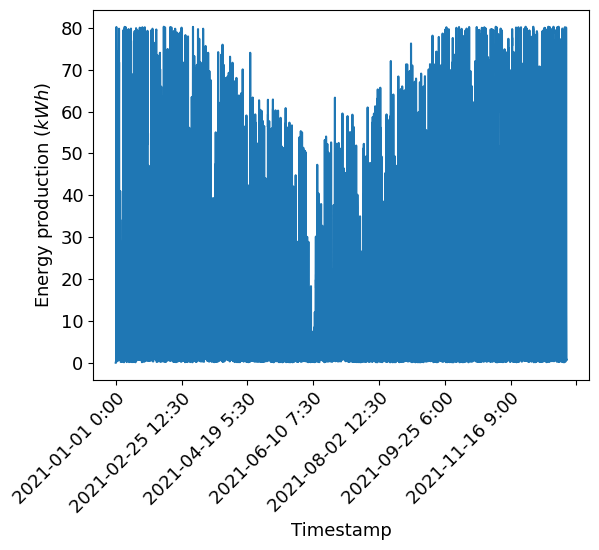

In [37]:
axxx = data_site_solar_generation[["Timestamp", "SolarGeneration"]].plot(x="Timestamp", y="SolarGeneration")
#xlab1 = ["huge (cpu-opt.)","small","large","c5a.2xlarge","c5a.2xlarge"]
#xlab2 = ["(Vienna)", "(Zurich)", "(Frankfurt)", "(Frankfurt)", "(London)"]
#xlabels = [f"{x1}\n{x2}" for x1, x2, in zip(xlab1,xlab2)]
plt.subplot().tick_params(labelsize=13)
plt.setp(axxx.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.xlabel("Timestamp", fontsize=13)
plt.ylabel("Energy production ($kWh$)", fontsize=13)
#plt.xticks(rotation=20)
plt.legend('',frameon=False)
plt.savefig("gen_time.png", format="png", bbox_inches="tight")

#### Visualise the average daily solar generation of the #25 SiteKey

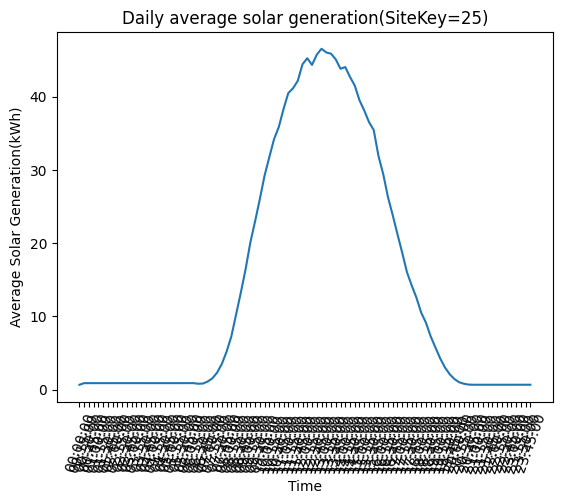

In [38]:
data_site_solar_generation['time']=pd.to_datetime(data_site_solar_generation['Timestamp']).dt.time.astype(str)
xaxis=data_site_solar_generation['time'].unique()
yaxis=data_site_solar_generation.groupby(['time'])['SolarGeneration'].mean()

plt.plot(xaxis,yaxis)

plt.title("Daily average solar generation(SiteKey=25)")
plt.xlabel("Time")
plt.ylabel("Average Solar Generation(kWh)")
plt.xticks(rotation=70)
plt.show()

In [39]:
X = data_site_solar_generation[['Month','Weekday','Hour','Minute','ApparentTemperature','Ghi']].to_numpy()
#X = np.hstack([weather_data["ApparentTemperature"].values.reshape(-1, 1),data_site_solar_generation[['Month','Weekday','Hour','Minute']].values])
print(np.shape(X))
print(type(X), " ", np.min(X[:,5]), " ", np.max(X[:,5]))
print()

Y = data_site_solar_generation['SolarGeneration'].to_numpy()
init_Y_len = Y.shape[0]
print(np.shape(Y))
print(type(Y))

(34256, 6)
<class 'numpy.ndarray'>   0.0   1091.0

(34256,)
<class 'numpy.ndarray'>


In [40]:
import calendar

def findDay(date):
	year, month, day = (int(i) for i in date.split('-')) 
	return calendar.weekday(year, month, day)

In [41]:
temp_irra_interpolatiiing_path = BASE_PATH + 'temp_irra_interpolatiiing_with_ghi.csv'
temp_irra_interpolatiiing = pd.read_csv(temp_irra_interpolatiiing_path)

##print("Before: ", X.shape[0])
init_x_len = X.shape[0]
X = np.resize(X,(init_x_len+(24*4),6))
##print("After: ", X.shape[0])

for i in range (24*4):
    X[init_x_len+i][0] = temp_irra_interpolatiiing['time'][i][5:7] # adding the Month
    X[init_x_len+i][1] = findDay(temp_irra_interpolatiiing['time'][i][0:10]) # adding the Weekday
    X[init_x_len+i][2] = temp_irra_interpolatiiing['time'][i][11:13] # adding the Hour
    X[init_x_len+i][3] = temp_irra_interpolatiiing['time'][i][14:16] # adding the Hour
    X[init_x_len+i][4] = temp_irra_interpolatiiing['temperature'][i] # adding the temperature to X data
    X[init_x_len+i][5] = temp_irra_interpolatiiing['GHI_est'][i] # adding the ghi
    #print(X[init_x_len+i])

Y = np.resize(Y,(init_Y_len+(24*4),1))

In [42]:
# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle = False) # , random_state=42
X_train2, X_val, Y_train2, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle = False) # , random_state=42
print("Train: ", np.max(X_train), " ", (X_train.shape))
#print("Val: ", np.max(X_val), " ", (X_val.shape))
print("Test: ", np.max(X_test), " ", (X_test.shape))
len_of_x_test_original = X_test.shape[0] - (24*4)

# Fit scaler only on training data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1,1))
Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1,1))
Y_val_scaled = scaler_Y.transform(Y_val.reshape(-1,1))
X_test_original = scaler_X.inverse_transform(X_test_scaled)
Y_test_original = scaler_Y.inverse_transform(Y_test_scaled)
X_val_original = scaler_X.inverse_transform(X_val_scaled)
Y_val_original = scaler_Y.inverse_transform(Y_val_scaled)

Train:  1078.0   (27481, 6)
Test:  1091.0   (6871, 6)


In [43]:
gbr = GradientBoostingRegressor(subsample=.7,
                                learning_rate=.5,
                                n_estimators=7,
                                max_depth=200,                                
                                min_samples_split=10,
                                min_samples_leaf=5,
                                loss="squared_error",
                                ).fit(X_train_scaled, Y_train_scaled)

In [44]:
#gbr.score(X_val, Y_val)
Y_predict_gbr_scaled = gbr.predict(X_test_scaled)
Y_predict_gbr = scaler_Y.inverse_transform(Y_predict_gbr_scaled.reshape(-1, 1))
Y_predict_gbr = np.where(Y_predict_gbr>=0.0, Y_predict_gbr, 0)

[9.245589038401018, 5.571467343486057, 3.756559808862688, 2.879044010356035, 2.382147600919319, 2.043124568353, 1.8463031585595886]


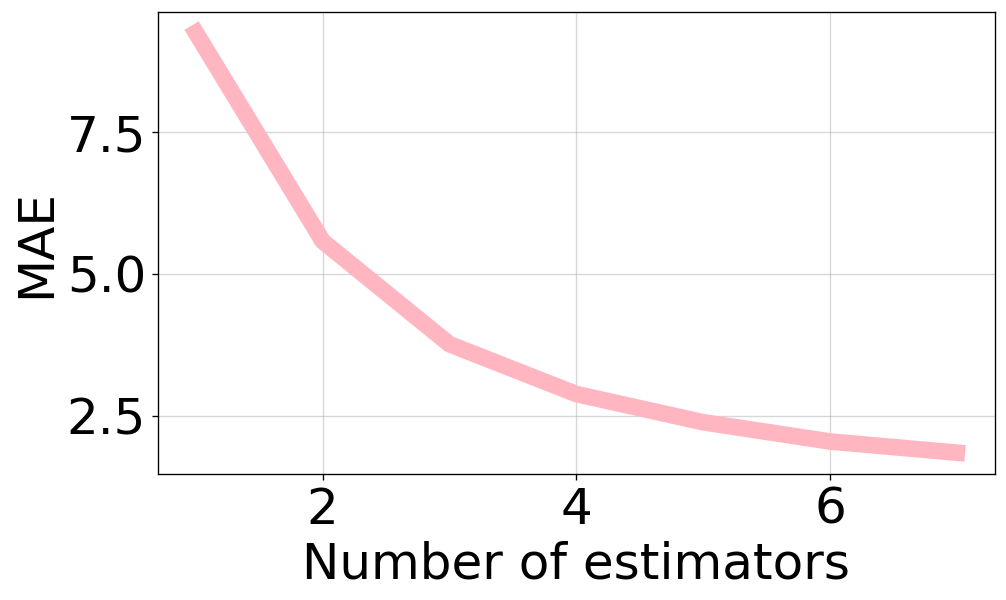

In [45]:
mae_gbr = []
for Y_predict_gbrr_scaled in gbr.staged_predict(X_val_scaled):
   Y_predict_gbrr = scaler_Y.inverse_transform(Y_predict_gbrr_scaled.reshape(-1, 1))
   mae_gbr.append(mean_absolute_error(Y_val_original, Y_predict_gbrr))
print(mae_gbr)
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
ax.plot(np.arange(1, gbr.n_estimators + 1), mae_gbr, color='lightpink', linewidth=10)
plt.subplot().tick_params(labelsize=30)
ax.set_xlabel('Number of estimators', fontsize=30)
ax.set_ylabel('MAE', fontsize=30)
ax.grid(True, alpha=0.5)
#plt.show()
plt.savefig("gbr-validation.pdf", format="pdf", bbox_inches="tight")

In [46]:
mae = mean_absolute_error(Y_test_original, Y_predict_gbr)
mse = mean_squared_error(Y_test_original, Y_predict_gbr)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_gbr)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 7.0560471599197525
MSE : 150.0983256410399
RMSE: 12.251462183798305
R2  : 0.78


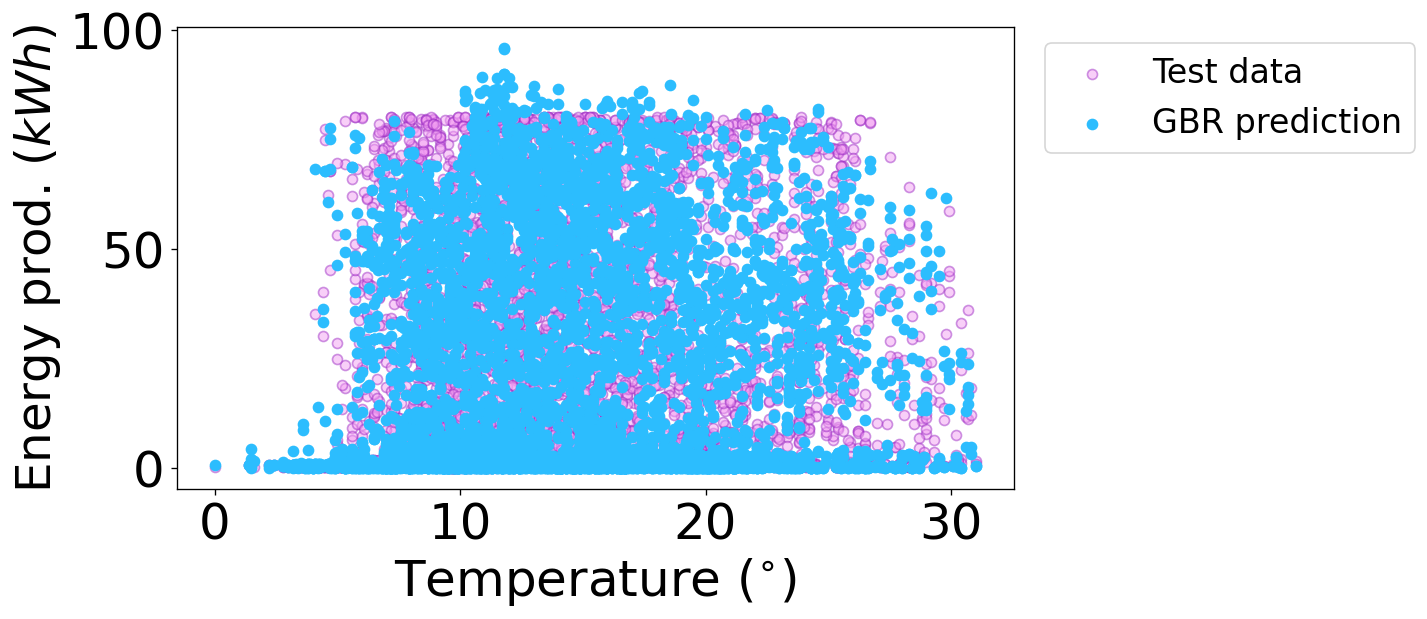

In [47]:
plt.figure(figsize=(9, 5), dpi=120)
plt.scatter(x=X_test_original[:,4], y=Y_test_original, color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=X_test_original[:,4], y=Y_predict_gbr, color="#2CBDFE", linewidth=1, label='GBR prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("gbr_prediction.png", format="png", bbox_inches="tight")

In [48]:
pd.DataFrame(np.hstack((
                        np.array(np.round(X_test_original[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 6)), 
                        np.array(np.round(Y_test_original[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_gbr[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1)
                       )), columns=['Month','Weekday(0=Monday,..., 6=Sunday)','Hour','Minute','Temperature','Ghi', 'Actual Energy (kW)',
                                     'Predicted Energy (kWh)']).to_csv('pv_prediction_data_gbr.csv', index=False)  # No index to be saved in the file

### HGBR

In [49]:
from sklearn.ensemble import HistGradientBoostingRegressor
hgbr = HistGradientBoostingRegressor().fit(X_train_scaled, Y_train_scaled)
Y_predict_hgbr_scaled = hgbr.predict(X_test_scaled)
Y_predict_hgbr = scaler_Y.inverse_transform(Y_predict_hgbr_scaled.reshape(-1, 1))
Y_predict_hgbr = np.where(Y_predict_hgbr>=0.0, Y_predict_hgbr, 0)

In [50]:
mae = mean_absolute_error(Y_test_original, Y_predict_hgbr)
mse = mean_squared_error(Y_test_original, Y_predict_hgbr)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_hgbr)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 6.294600378830568
MSE : 115.20927859819118
RMSE: 10.733558524468537
R2  : 0.83


[15.58637727063436, 14.279294272007276, 13.112026111999374, 12.098096143251277, 11.220025697951439, 10.451212823172362, 9.78873911345423, 9.1997036544401, 8.667827465816199, 8.205552978525873, 7.8053254995973385, 7.452328597827178, 7.133983276324377, 6.851854155597518, 6.5939868053919035, 6.356683035089549, 6.160897582557634, 5.960609509051332, 5.7986940866730015, 5.635425506537949, 5.498189665102465, 5.362629378117706, 5.260321081132124, 5.150069216313354, 5.054886773077579, 4.975557082928771, 4.90950519884358, 4.845204447254546, 4.7726610705940695, 4.726703743567077, 4.669809704167889, 4.623254912066721, 4.585648892284125, 4.551146645635441, 4.514303472150205, 4.458964997209148, 4.402230380568336, 4.374497741323304, 4.350681358049171, 4.3131274718640356, 4.2879683802300415, 4.267728725290983, 4.227000815181365, 4.20415484109232, 4.184088673864497, 4.156167416826095, 4.1388816504186, 4.130433561096896, 4.114495111027463, 4.105853502979263, 4.090317578310826, 4.072969812328875, 4.05717

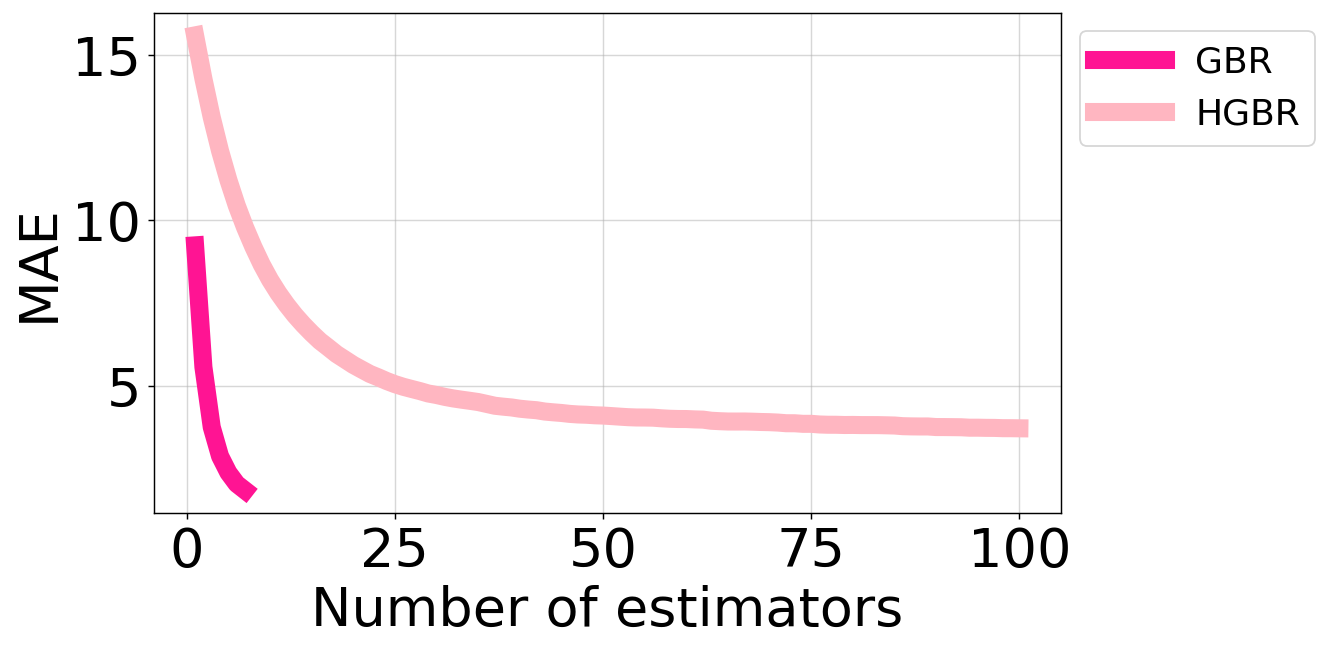

In [51]:
mae_hgbr = []
for Y_predict_hgbrr_scaled in hgbr.staged_predict(X_val_scaled):
   Y_predict_hgbrr = scaler_Y.inverse_transform(Y_predict_hgbrr_scaled.reshape(-1, 1))
   mae_hgbr.append(mean_absolute_error(Y_val_original, Y_predict_hgbrr))
print(mae_hgbr)
fig, ax = plt.subplots(figsize=(9, 5), dpi=130)
ax.plot(np.arange(1, gbr.n_estimators + 1), mae_gbr, color='deeppink', linewidth=10, label = "GBR")
plt.plot(np.arange(1, len(mae_hgbr) + 1), mae_hgbr, color='lightpink', linewidth=10, label = "HGBR")
plt.subplot().tick_params(labelsize=30)
ax.set_xlabel('Number of estimators', fontsize=30)
ax.set_ylabel('MAE', fontsize=30)
ax.grid(True, alpha=0.5)
plt.legend(bbox_to_anchor =(1.3,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("gbr_hgbr-validation.pdf", format="pdf", bbox_inches="tight")

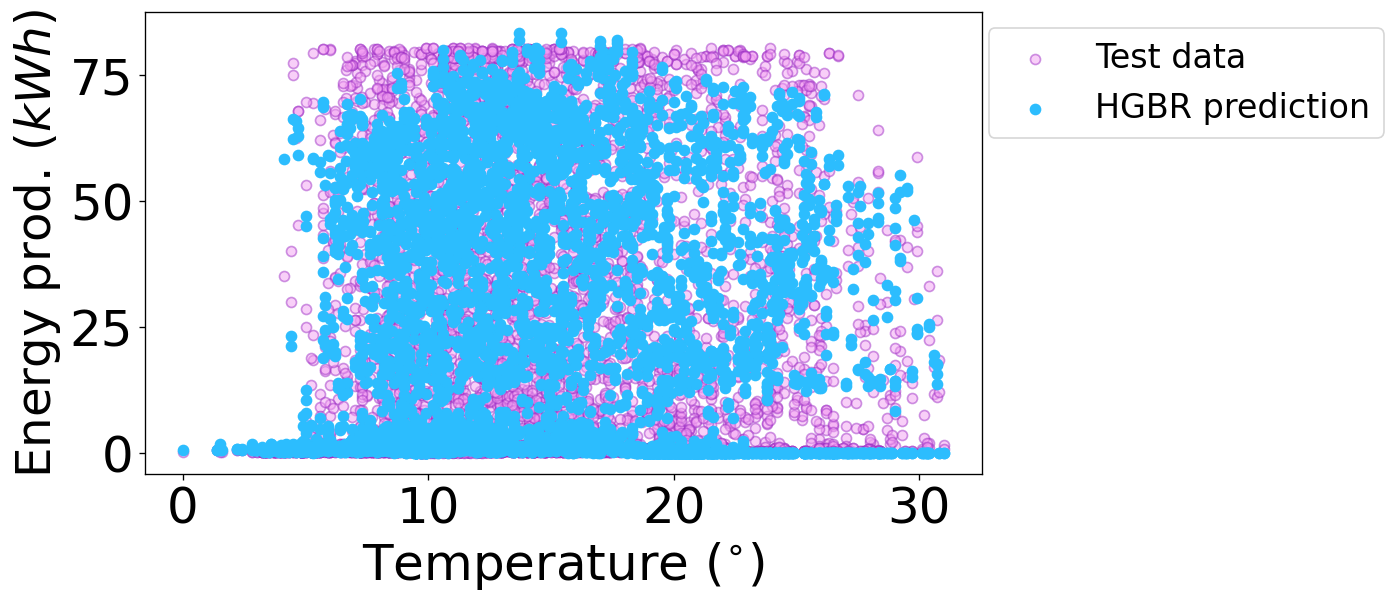

In [52]:
plt.figure(figsize=(9, 5), dpi=120)
plt.scatter(x=X_test_original[:,4], y=Y_test_original, color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=X_test_original[:,4], y=Y_predict_hgbr, color="#2CBDFE", linewidth=1, label='HGBR prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("hgbr_prediction.png", format="png", bbox_inches="tight")

In [53]:
pd.DataFrame(np.hstack((
                        np.array(np.round(X_test_original[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 6)), 
                        np.array(np.round(Y_test_original[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_hgbr[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1)
                       )), columns=['Month','Weekday(0=Monday,..., 6=Sunday)','Hour','Minute','Temperature','Ghi', 'Actual Energy (kW)',
                                     'Predicted Energy (kWh)']).to_csv('pv_prediction_data_hgbr.csv', index=False)  # No index to be saved in the file

### MLP

In [54]:
mlp_sk_learn = MLPRegressor(solver = 'adam', max_iter = 10000)

# Train a model
mlp_sk_learn.fit(X_train_scaled,Y_train_scaled)
Y_predict_mlp_scaled = mlp_sk_learn.predict(X_test_scaled)
Y_predict_mlp = scaler_Y.inverse_transform(Y_predict_mlp_scaled.reshape(-1, 1))
Y_predict_mlp = np.where(Y_predict_mlp>=0.0, Y_predict_mlp, 0)

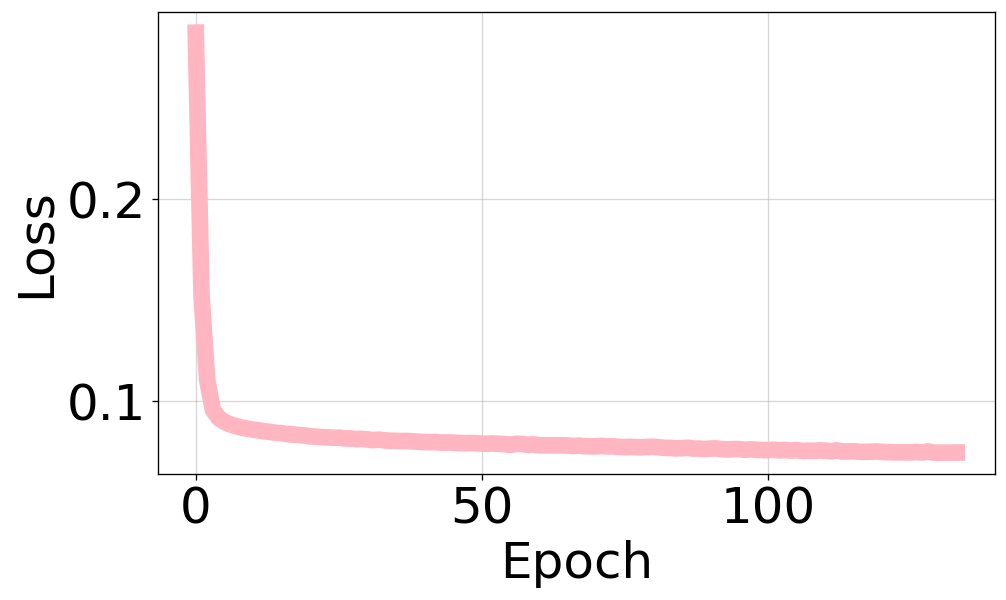

In [55]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
ax.plot(mlp_sk_learn.loss_curve_, color='lightpink', linewidth=10)
plt.subplot().tick_params(labelsize=30)
ax.set_xlabel('Epoch', fontsize=30)
ax.set_ylabel('Loss', fontsize=30)
ax.grid(True, alpha=0.5)
#plt.show()
plt.savefig("mlp_validation.pdf", format="pdf", bbox_inches="tight")

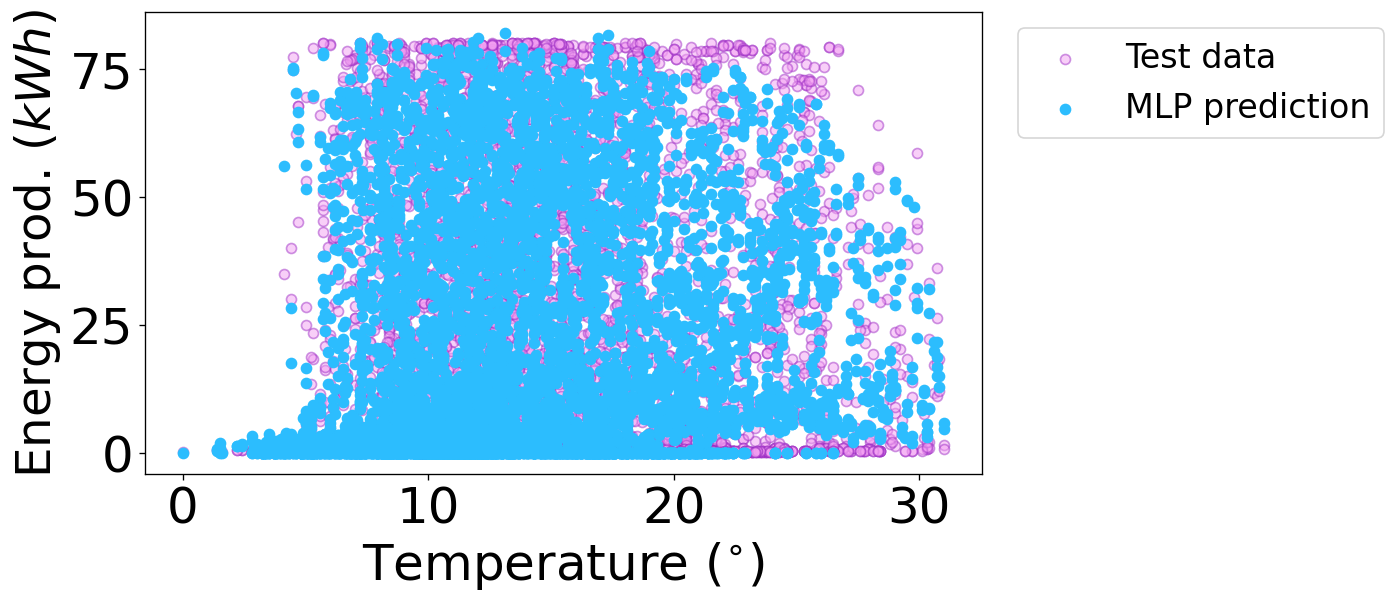

In [56]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=X_test_original[:,4], y=Y_test_original, color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=X_test_original[:,4], y=Y_predict_mlp, color="#2CBDFE", linewidth=1, label='MLP prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("mlp_prediction.png", format="png", bbox_inches="tight")

In [57]:
mae = mean_absolute_error(Y_test_original, Y_predict_mlp)
mse = mean_squared_error(Y_test_original, Y_predict_mlp)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test_original, Y_predict_mlp)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_mlp)
#mae = mean_absolute_error(Y_val, Y_predict_mlp)
#mse = mean_squared_error(Y_val, Y_predict_mlp)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 6.663608343268406
MSE : 112.32009802011186
RMSE: 10.598117664005805
R2  : 0.84


In [58]:
pd.DataFrame(np.hstack((
                        np.array(np.round(X_test_original[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 6)), 
                        np.array(np.round(Y_test_original[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(Y_predict_mlp[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1)
                       )), columns=['Month','Weekday(0=Monday,..., 6=Sunday)','Hour','Minute','Temperature','Ghi', 'Actual Energy (kW)',
                                     'Predicted Energy (kWh)']).to_csv('pv_prediction_data_mlp.csv', index=False)  # No index to be saved in the file

In [59]:
def create_model():
    model = Sequential([
    Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(1,6)),
    MaxPooling1D(1),
    LSTM(50),
    Dense(1, kernel_regularizer="l2")
    ])
    return model

def reshape_client_data(x, y, x_val, y_val):
    return (
        x.reshape((x.shape[0], 1, x.shape[1])),
        y.reshape(-1, 1),
        x_val.reshape((x_val.shape[0], 1, x_val.shape[1])),
        y_val.reshape(-1, 1)
    )

In [60]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reshape x to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

# Apply standard scaling
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_test_scaled = scaler_X.transform(X_test_reshaped)
X_val_scaled = scaler_X.transform(X_val_reshaped)

# Scale y if needed
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_val_scaled = scaler_Y.transform(Y_val)

cent_x, cent_y, cent_x_val, cent_y_val = reshape_client_data (X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled)
model_lstm = create_model()
model_lstm.compile(loss=Huber(), optimizer=Adam(learning_rate=0.0005))

# Summary the model to see if all layers are well combinated.
#model_lstm.summary()

# validation_split = 0.2 : 20% of X_train and y_train are using to test your model
history =  model_lstm.fit(cent_x, cent_y, validation_data=(cent_x_val, cent_y_val), epochs=6, batch_size=32, callbacks=[early_stop], verbose=0)

X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))
Y_predict_lstm_scaled = model_lstm.predict(X_test_reshaped) # scale the data with the max_value of the training
Y_predict_lstm = scaler_Y.inverse_transform(Y_predict_lstm_scaled.reshape(-1, 1)) # Inverse transform the predictions and the actual Y_test to get back to the original scale
Y_predict_lstm = np.where(Y_predict_lstm>=0.0, Y_predict_lstm, 0)

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


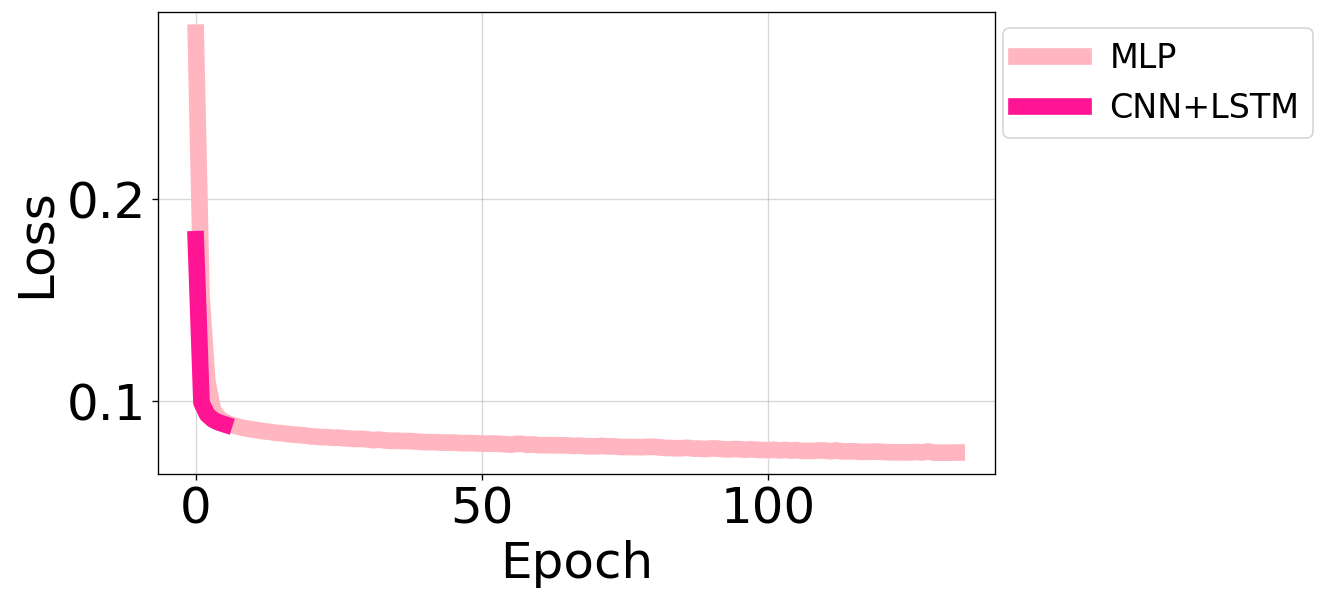

In [61]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=30)
plt.plot(mlp_sk_learn.loss_curve_, color='lightpink', linewidth=10, label = "MLP")
plt.plot(history.history['loss'], marker='+', color='deeppink', linewidth=10, label = "CNN+LSTM")
plt.xlabel("Epoch", fontsize=30)    
plt.ylabel("Loss", fontsize=30)
plt.legend(bbox_to_anchor =(1,1),fontsize=20)
ax.grid(True, alpha=0.5)
plt.legend(bbox_to_anchor =(1.4,1),fontsize=20, ncol=1)
plt.savefig("mlp_lstm_validation.pdf", format="pdf", bbox_inches="tight")

In [62]:
elapsed_time = time.monotonic() - start_time
print("Algorithm execution time: ", np.round(elapsed_time,4))

Algorithm execution time:  32.297
